In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.formula.api as sm
import scipy.stats as stats
import pandas_profiling

from sklearn import metrics
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices

In [3]:
bankloans=pd.read_csv('E:/Data Science with Python\Machine Learning/1. Case Study - Bank Loans/bankloans.csv')

In [4]:
bankloans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 850 entries, 0 to 849
Data columns (total 9 columns):
age         850 non-null int64
ed          850 non-null int64
employ      850 non-null int64
address     850 non-null int64
income      850 non-null int64
debtinc     850 non-null float64
creddebt    850 non-null float64
othdebt     850 non-null float64
default     700 non-null float64
dtypes: float64(4), int64(5)
memory usage: 59.8 KB


In [5]:
num_cols=[key for key in dict(bankloans.dtypes) if dict(bankloans.dtypes)[key] in ['int32','int64','float32','float64']]
cat_cols=[key for key in dict(bankloans.dtypes) if dict(bankloans.dtypes)[key] in ['object']]

In [6]:
bankloans_num=bankloans[num_cols]
bankloans_cat=bankloans[cat_cols]

In [7]:
def var_summary(x):
    return pd.Series([x.count(),x.isnull().sum(),x.sum(),x.mean(),x.median(),x.std(),x.var(),x.min(),x.dropna().quantile(0.01),x.dropna().quantile(0.05),x.dropna().quantile(0.10),x.dropna().quantile(0.25),x.dropna().quantile(0.50),x.dropna().quantile(0.75),x.dropna().quantile(0.99),x.max()],
                    index=['N','NMISS','SUM','MEAN','MEDIAN','STD','VAR','MIN','P1','P5','P10','P25','P50','P75','P99','MAX'])

In [8]:
summary_num=bankloans_num.apply(lambda x:var_summary(x)).T

In [9]:
summary_num

,N,NMISS,SUM,MEAN,MEDIAN,STD,VAR,MIN,P1,P5,P10,P25,P50,P75,P99,MAX
default,700.0,150.0,183.000000,0.261429,0.000000,0.439727,0.193360,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.00000
ed,850.0,0.0,1454.000000,1.710588,1.000000,0.927784,0.860783,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,4.000000,5.00000
age,850.0,0.0,29775.000000,35.029412,34.000000,8.041432,64.664623,20.000000,21.000000,23.000000,25.000000,29.000000,34.000000,41.000000,53.000000,56.00000
address,850.0,0.0,7116.000000,8.371765,7.000000,6.895016,47.541251,0.000000,0.000000,0.000000,1.000000,3.000000,7.000000,12.000000,26.510000,34.00000
employ,850.0,0.0,7281.000000,8.565882,7.000000,6.777884,45.939706,0.000000,0.000000,0.000000,1.000000,3.000000,7.000000,13.000000,29.000000,33.00000
debtinc,850.0,0.0,8645.900000,10.171647,8.700000,6.719441,45.150891,0.100000,0.900000,1.900000,2.900000,5.100000,8.700000,13.800000,31.565000,41.30000
income,850.0,0.0,39674.000000,46.675294,35.000000,38.543054,1485.566998,13.000000,14.490000,17.000000,19.000000,24.000000,35.000000,55.750000,220.510000,446.00000
othdebt,850.0,0.0,2616.970979,3.078789,2.003243,3.398803,11.551864,0.045584,0.162394,0.359900,0.552050,1.045942,2.003243,3.903001,16.931503,35.19750
creddebt,850.0,0.0,1340.284021,1.576805,0.885091,2.125840,4.519196,0.011696,0.030349,0.108927,0.178306,0.382176,0.885091,1.898440,10.285997,20.56131


In [10]:
pandas_profiling.ProfileReport(bankloans)

Number of variables,9
Number of observations,850
Total Missing (%),0.0%
Total size in memory,59.8 KiB
Average record size in memory,72.0 B
Numeric,9
Categorical,0
Boolean,0
Date,0
Text (Unique),0
Rejected,0


In [11]:
bankloans_existing=bankloans_num[bankloans_num['default'].isnull()==0]
bankloans_new=bankloans_num[bankloans_num['default'].isnull()==1]

In [12]:
def outlier_treat(x):
    x=x.clip_upper(x.quantile(0.99))
    x=x.clip_lower(x.quantile(0.01))
    return x

bankloans_existing=bankloans_existing.apply(lambda x:outlier_treat(x))

In [13]:
def missing_treat(x):
    x=x.fillna(x.mean())
    return x

bankloans_existing=bankloans_existing.apply(lambda x: missing_treat(x))

In [14]:
bankloans_existing.corr()

,default,ed,age,address,employ,debtinc,income,othdebt,creddebt
default,1.000000,0.118521,-0.138654,-0.165389,-0.287197,0.388556,-0.099553,0.138962,0.238179
ed,0.118521,1.000000,0.016576,0.055560,-0.158071,0.009992,0.225395,0.156523,0.103012
age,-0.138654,0.016576,1.000000,0.596973,0.537417,0.016926,0.521450,0.348911,0.308318
address,-0.165389,0.055560,0.596973,1.000000,0.324859,0.014967,0.345067,0.234896,0.215397
employ,-0.287197,-0.158071,0.537417,0.324859,1.000000,-0.035332,0.665369,0.419337,0.405959
debtinc,0.388556,0.009992,0.016926,0.014967,-0.035332,1.000000,-0.022541,0.603630,0.534602
income,-0.099553,0.225395,0.521450,0.345067,0.665369,-0.022541,1.000000,0.626787,0.553114
othdebt,0.138962,0.156523,0.348911,0.234896,0.419337,0.603630,0.626787,1.000000,0.639984
creddebt,0.238179,0.103012,0.308318,0.215397,0.405959,0.534602,0.553114,0.639984,1.000000


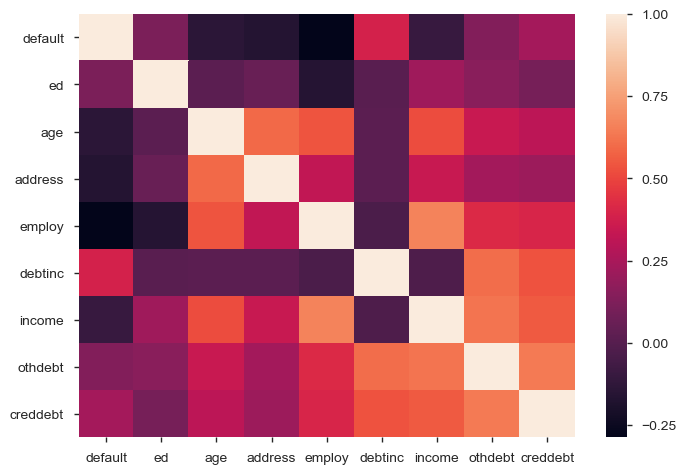

In [27]:
sns.heatmap(bankloans_existing.corr())

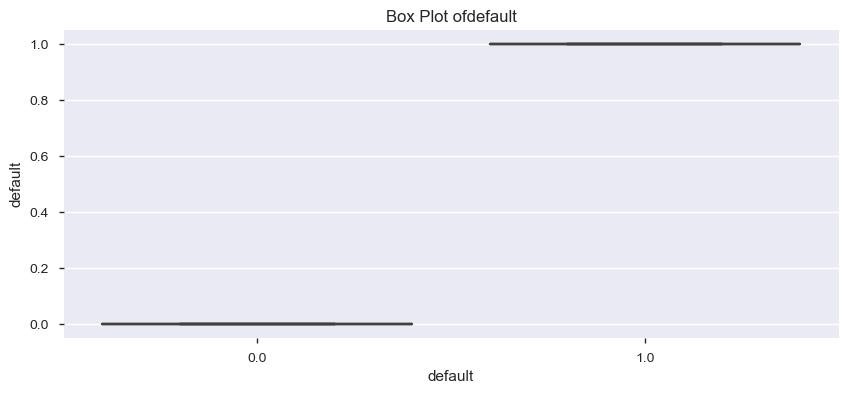

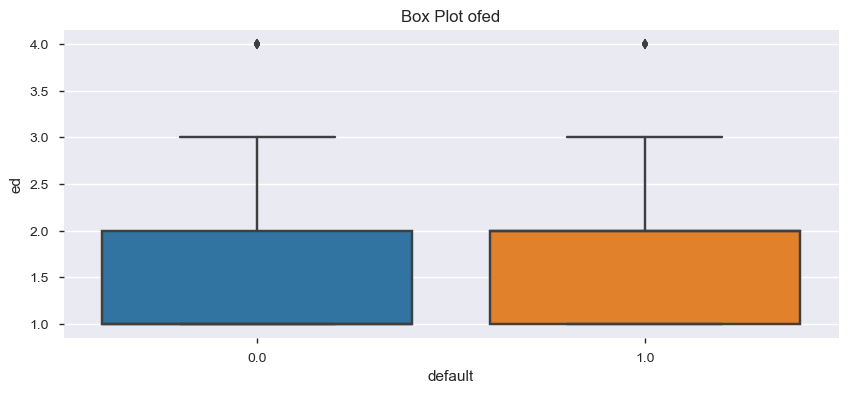

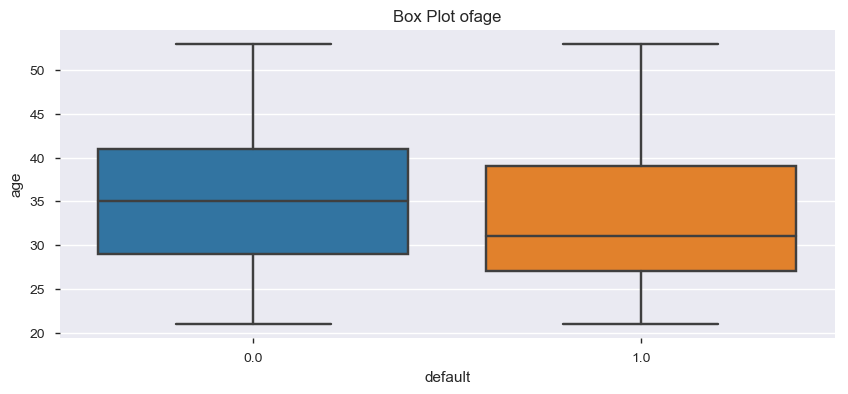

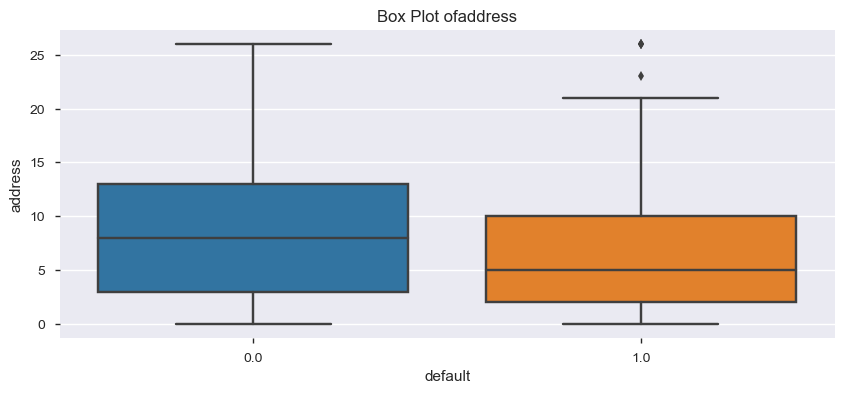

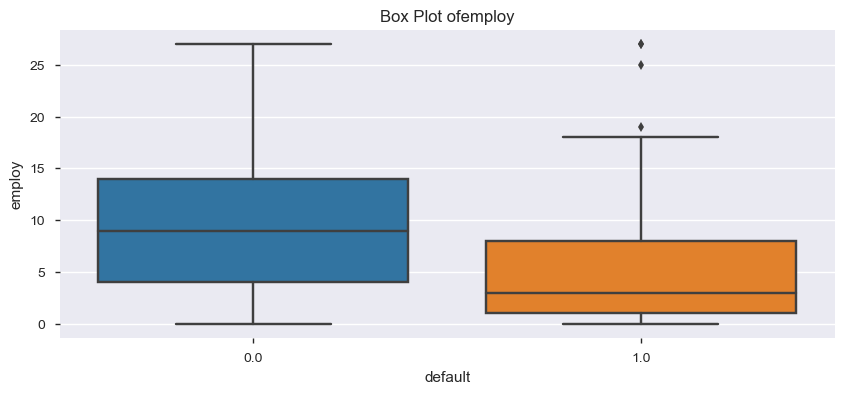

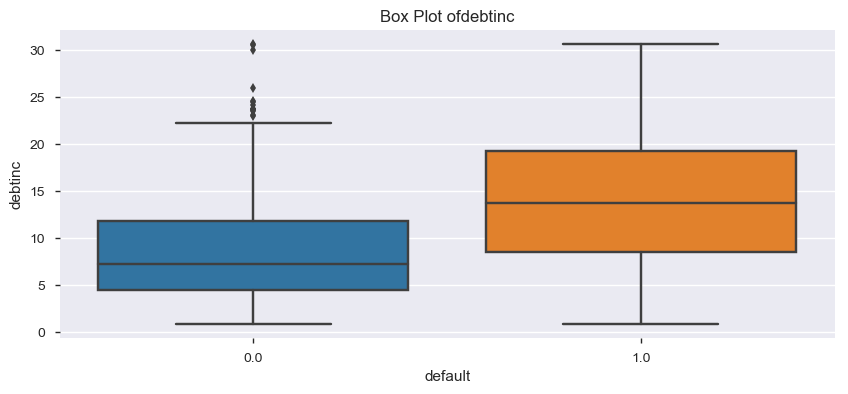

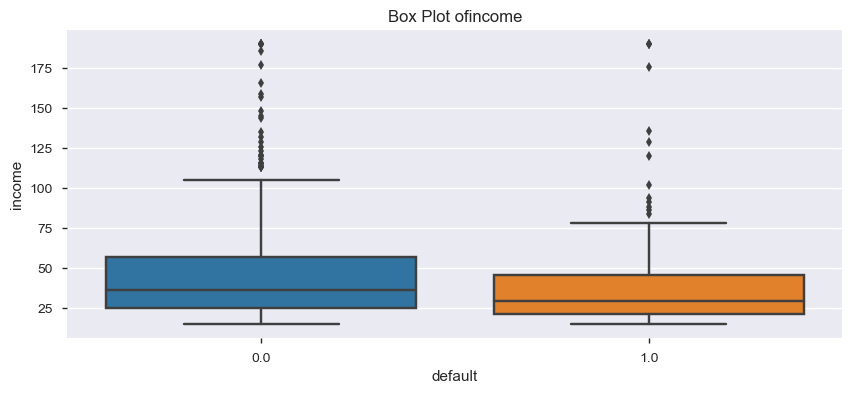

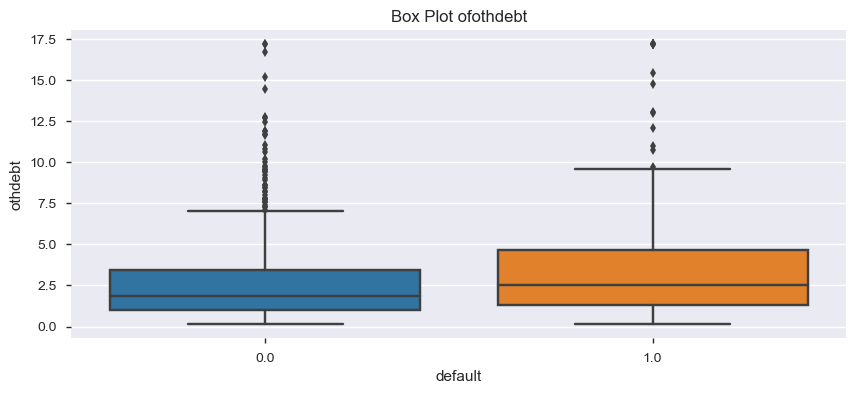

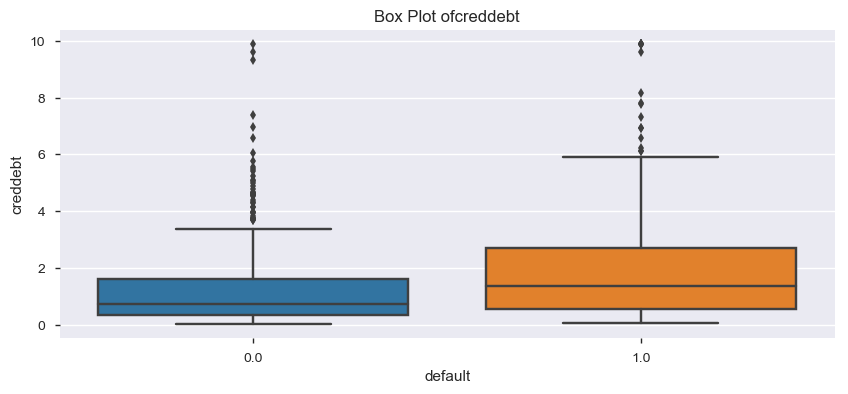

In [15]:
for n1 in num_cols:
    fig,axes=plt.subplots(figsize=(10,4))
    sns.boxplot(x='default',y=n1,data=bankloans_existing)
    plt.title(str('Box Plot of') + str(n1))

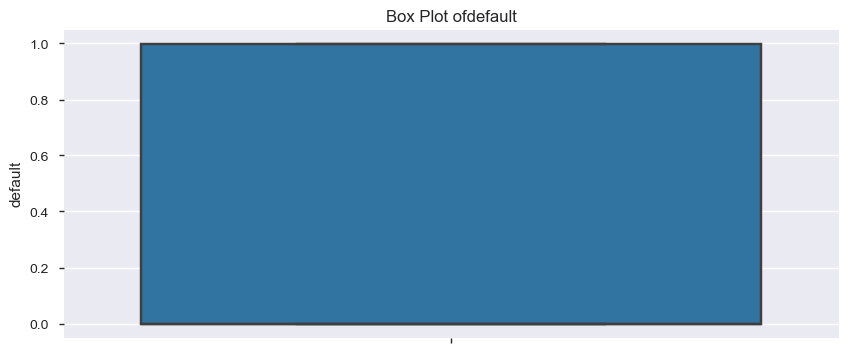

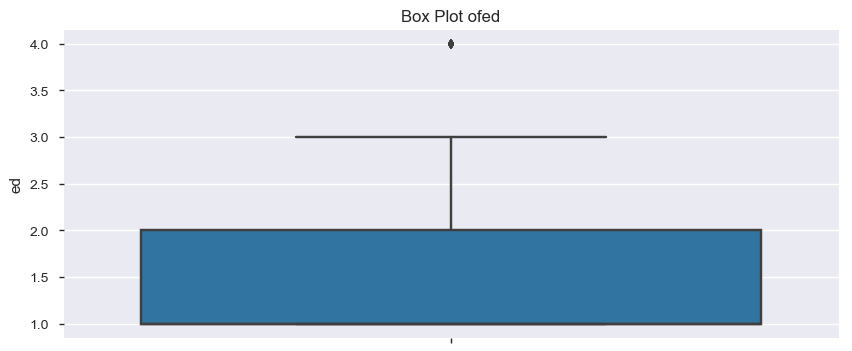

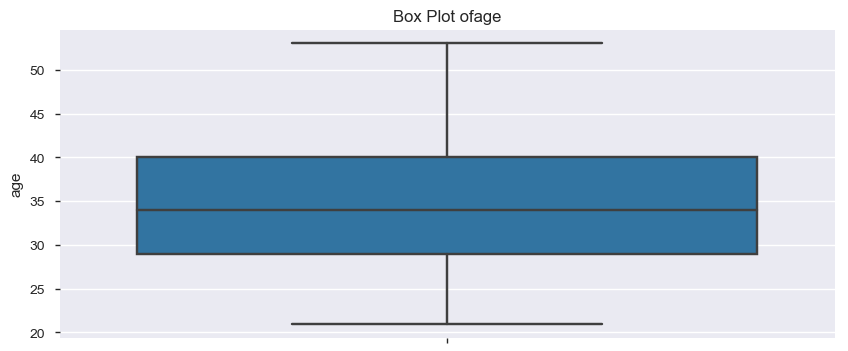

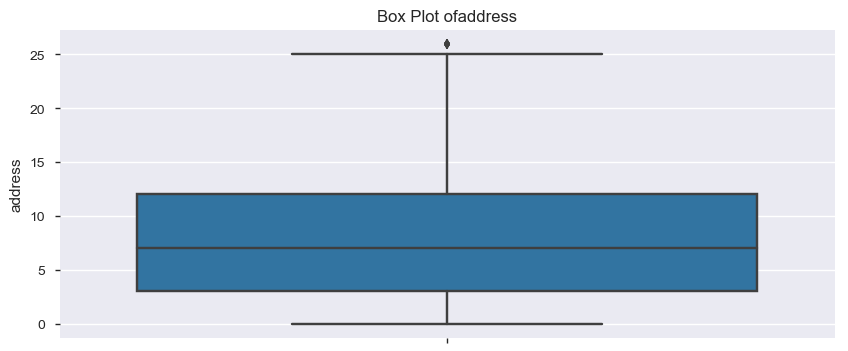

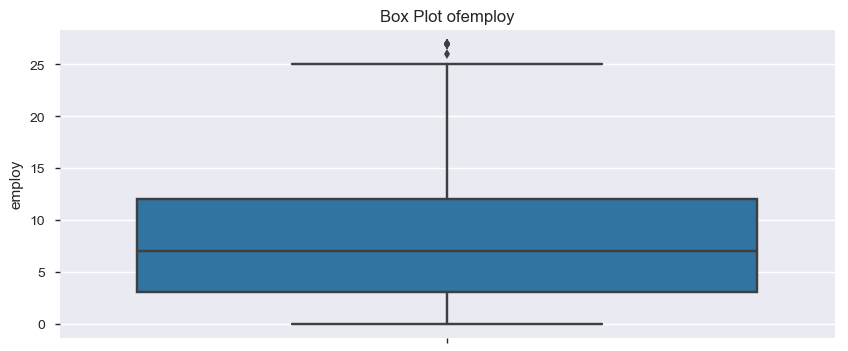

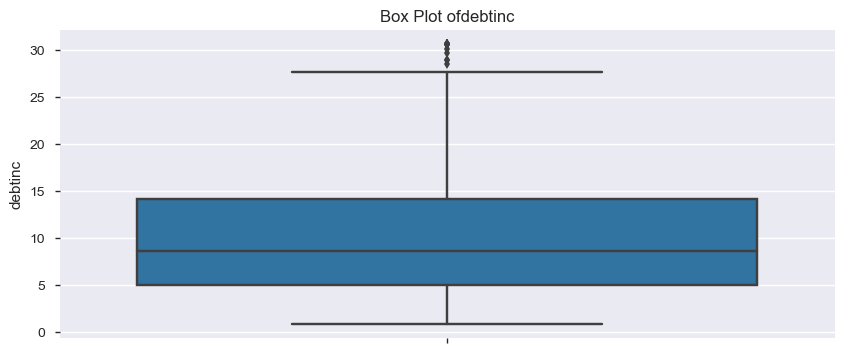

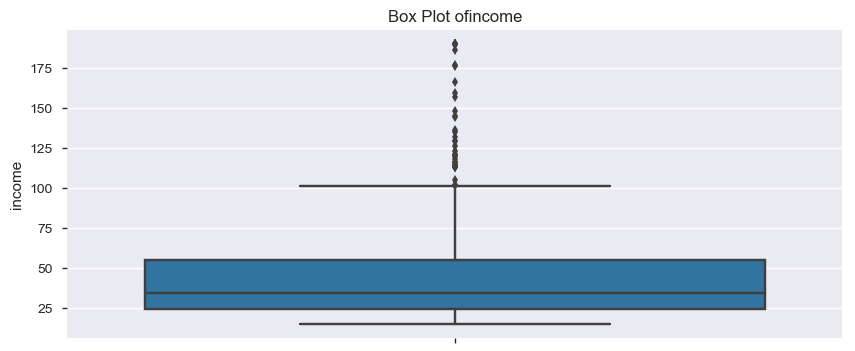

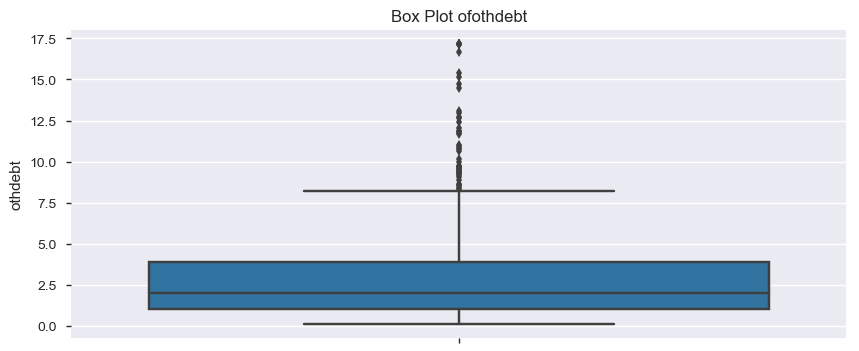

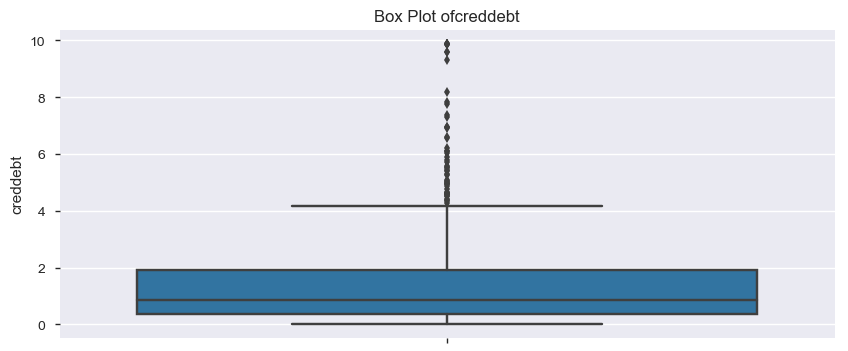

In [16]:
for n1 in num_cols:
    fig,axes=plt.subplots(figsize=(10,4))
    sns.boxplot(y=n1,data=bankloans_existing)
    plt.title(str('Box Plot of') + str(n1))

In [17]:
tstats_df=pd.DataFrame()
for n1 in num_cols:
    tstats=stats.ttest_ind(bankloans_existing[bankloans_existing['default']==1][n1],bankloans_existing[bankloans_existing['default']==0][n1])
    temp=pd.DataFrame([n1,tstats[0],tstats[1]]).T
    temp.columns=['Variable','T-statistic','P-Value']
    tstats_df=pd.concat([tstats_df,temp],axis=0,ignore_index=True)

In [18]:
tstats_df

,Variable,T-statistic,P-Value
0,default,inf,0
1,ed,3.15351,0.00168236
2,age,-3.69893,0.000233527
3,address,-4.43055,1.09104e-05
4,employ,-7.92136,9.27995e-15
5,debtinc,11.1409,1.20241e-26
6,income,-2.64329,0.00839468
7,othdebt,3.7073,0.000226095
8,creddebt,6.47909,1.7428e-10


C:\Users\Ritesh Agarwal\Anaconda2\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


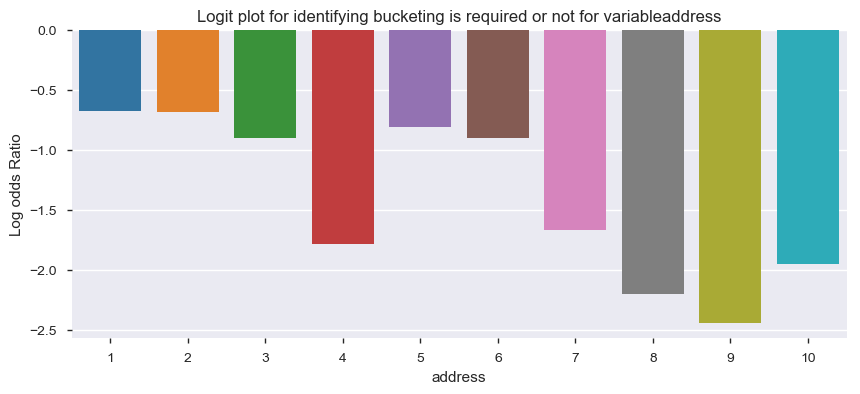

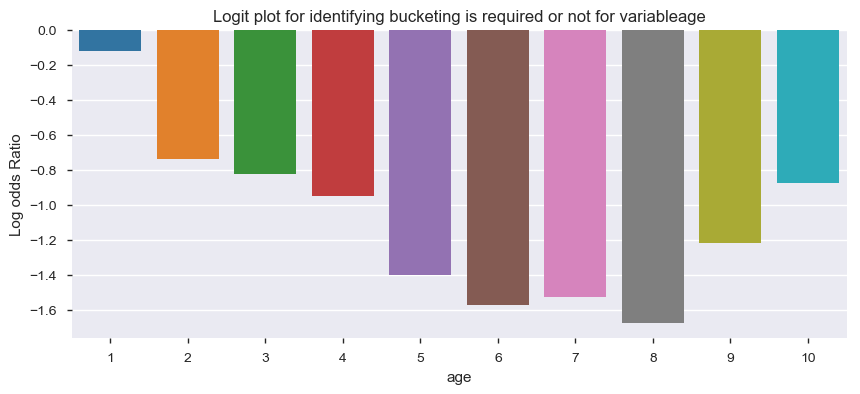

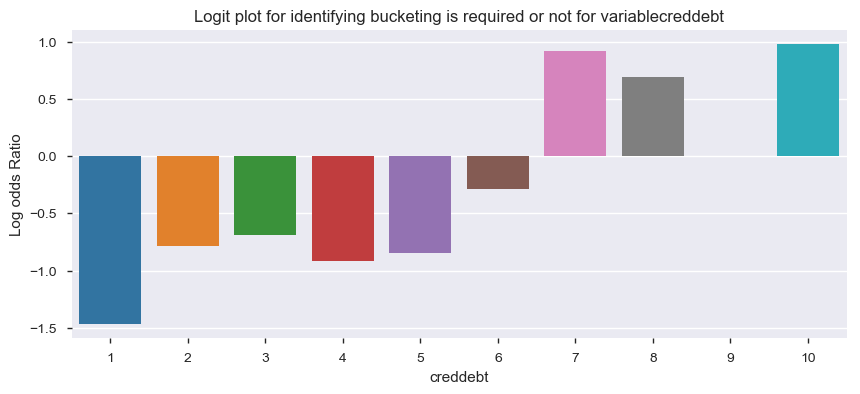

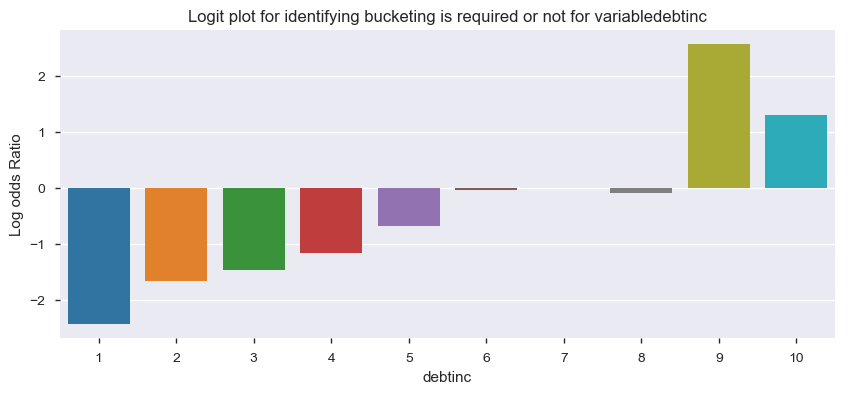

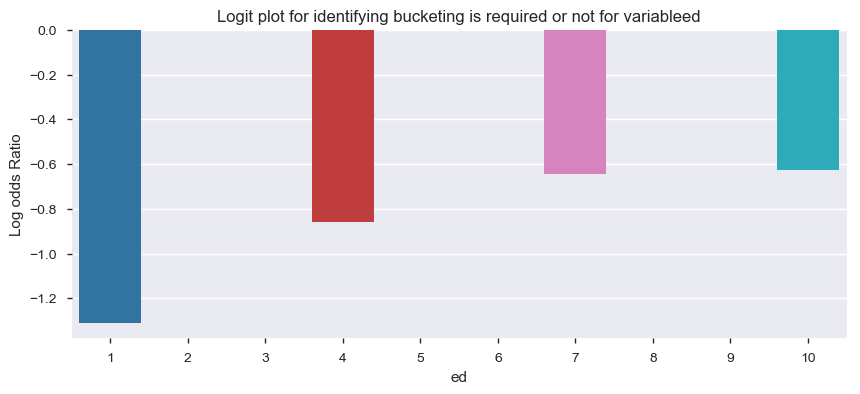

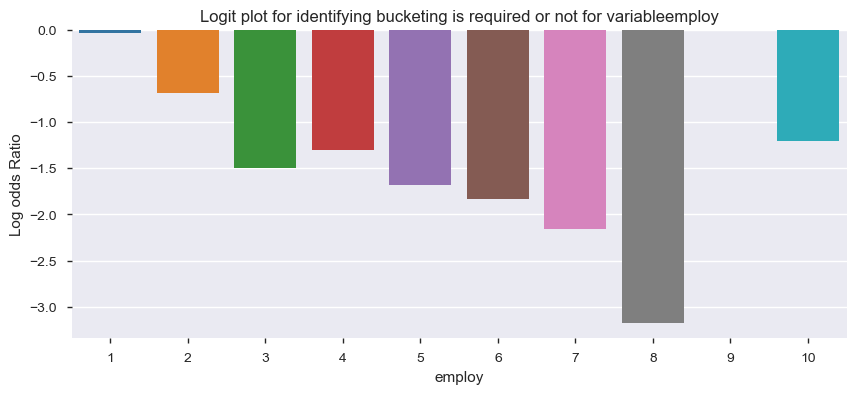

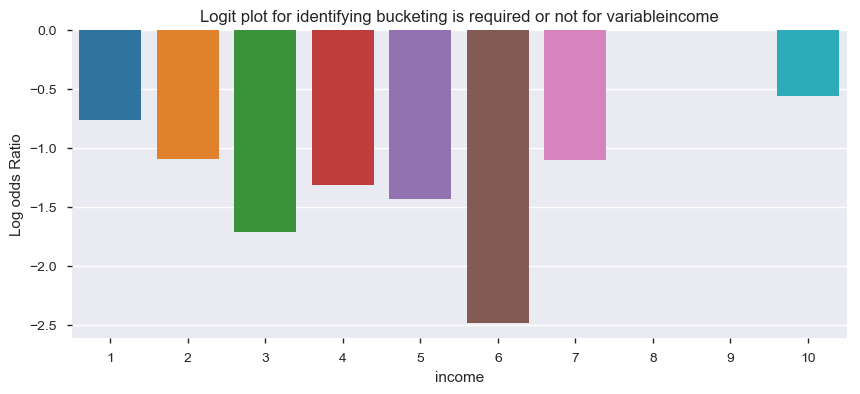

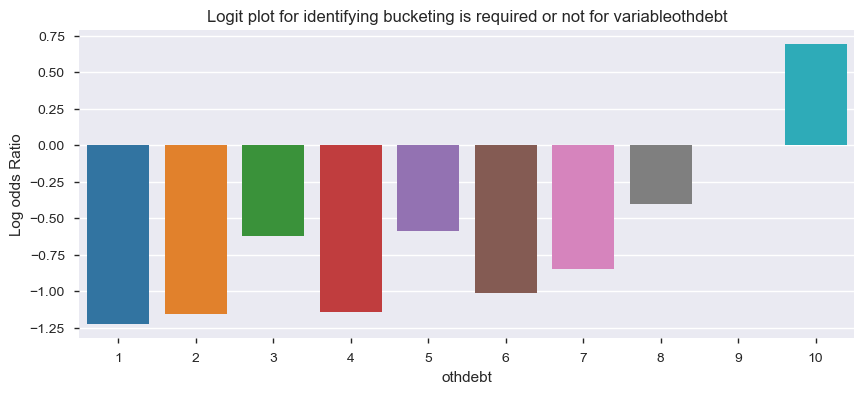

In [19]:
for n1 in bankloans_existing.columns.difference(['default']):
    binned=pd.cut(bankloans_existing[n1],bins=10,labels=list(range(1,11)))
    binned=binned.dropna()
    ser=bankloans_existing.groupby(binned)['default'].sum()/(bankloans_existing.groupby(binned)['default'].count()-bankloans_existing.groupby(binned)['default'].sum())
    ser=np.log(ser)
    fig,axes=plt.subplots(figsize=(10,4))
    sns.barplot(x=ser.index,y=ser)
    plt.ylabel('Log odds Ratio')
    plt.title(str('Logit plot for identifying bucketing is required or not for variable')+str(n1))

In [20]:
bankloans_existing[['address','creddebt','debtinc','employ','income','othdebt']].describe(percentiles=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]).T

,count,mean,std,min,10%,20%,30%,40%,50%,60%,70%,80%,90%,max
address,700.0,8.244386,6.721915,0.000000,1.000000,2.000000,3.000000,5.000000,7.000000,9.000000,11.000000,14.000000,18.000000,26.010000
creddebt,700.0,1.498843,1.788451,0.030209,0.170020,0.301390,0.440418,0.593059,0.854869,1.183471,1.615023,2.288026,3.621504,9.891428
debtinc,700.0,10.222153,6.682160,0.900000,2.900000,4.500000,5.800000,7.000000,8.600000,10.500000,12.900000,15.440000,19.610000,30.701000
employ,700.0,8.358671,6.566008,0.000000,1.000000,2.000000,4.000000,5.600000,7.000000,9.000000,11.000000,14.000000,18.000000,27.010000
income,700.0,44.848714,31.942133,15.000000,19.000000,22.000000,26.000000,29.000000,34.000000,40.400000,49.000000,61.000000,82.000000,190.300000
othdebt,700.0,3.027290,3.115401,0.160936,0.562232,0.900747,1.165766,1.546101,1.987567,2.511054,3.258777,4.577926,7.036180,17.184744


In [21]:
bankloans_existing['address_extreme']=bankloans_existing['address'].apply(lambda x: 0 if x<=5 else 1 if 5<x<=14 else 2)
bankloans_existing['creddebt_extreme']=bankloans_existing['creddebt'].apply(lambda x: 0 if x<=0.45 else 1 if 0.45<x<=1.18 else 2)
bankloans_existing['debtinc_extreme']=bankloans_existing['debtinc'].apply(lambda x: 0 if x<=5.8 else 1 if 5.8<x<=15.44 else 2)
bankloans_existing['employ_extreme']=bankloans_existing['employ'].apply(lambda x: 0 if 0<x<=7.0 else 1)
bankloans_existing['income_extreme']=bankloans_existing['income'].apply(lambda x: 0 if x<=29 else 1)
bankloans_existing['othdebt_extreme']=bankloans_existing['othdebt'].apply(lambda x: 0 if x<=1.17 else 1 if 1.17<x<=2.6 else 2)

In [22]:
def create_dummy(df,col):
    col_dummy=pd.get_dummies(df[col],prefix=col)
    col_dummy.drop(col_dummy.columns[0],axis=1,inplace=True)
    df=pd.concat([df,col_dummy],axis=1)
    df.drop(col,axis=1,inplace=True)
    return df

for feature in ['address_extreme','creddebt_extreme','debtinc_extreme','employ_extreme','income_extreme','othdebt_extreme']:
    bankloans_existing[feature]=bankloans_existing[feature].astype('category')
    bankloans_existing=create_dummy(bankloans_existing,feature)

In [23]:
bankloans_existing.head(10)

,default,ed,age,address,employ,debtinc,income,othdebt,creddebt,address_extreme_1,address_extreme_2,creddebt_extreme_1,creddebt_extreme_2,debtinc_extreme_1,debtinc_extreme_2,employ_extreme_1,income_extreme_1,othdebt_extreme_1,othdebt_extreme_2
0,1.0,3.0,41.0,12.0,17.0,9.3,176.0,5.008608,9.891428,1,0,0,1,1,0,1,1,0,1
1,0.0,1.0,27.0,6.0,10.0,17.3,31.0,4.000798,1.362202,1,0,0,1,0,1,1,1,0,1
2,0.0,1.0,40.0,14.0,15.0,5.5,55.0,2.168925,0.856075,1,0,1,0,0,0,1,1,1,0
3,0.0,1.0,41.0,14.0,15.0,2.9,120.0,0.821280,2.658720,1,0,0,1,0,0,1,1,0,0
4,1.0,2.0,24.0,0.0,2.0,17.3,28.0,3.056564,1.787436,0,0,0,1,0,1,0,0,0,1
5,0.0,2.0,41.0,5.0,5.0,10.2,25.0,2.157300,0.392700,0,0,0,0,1,0,0,0,1,0
6,0.0,1.0,39.0,9.0,20.0,30.6,67.0,16.668126,3.833874,1,0,0,1,0,1,1,1,0,1
7,0.0,1.0,43.0,11.0,12.0,3.6,38.0,1.239408,0.128592,1,0,0,0,0,0,1,1,1,0
8,1.0,1.0,24.0,4.0,3.0,24.4,19.0,3.277652,1.358348,0,0,0,1,0,1,0,0,0,1
9,0.0,1.0,36.0,13.0,0.0,19.7,25.0,2.147300,2.777700,1,0,0,1,0,1,1,0,1,0


C:\Users\Ritesh Agarwal\Anaconda2\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


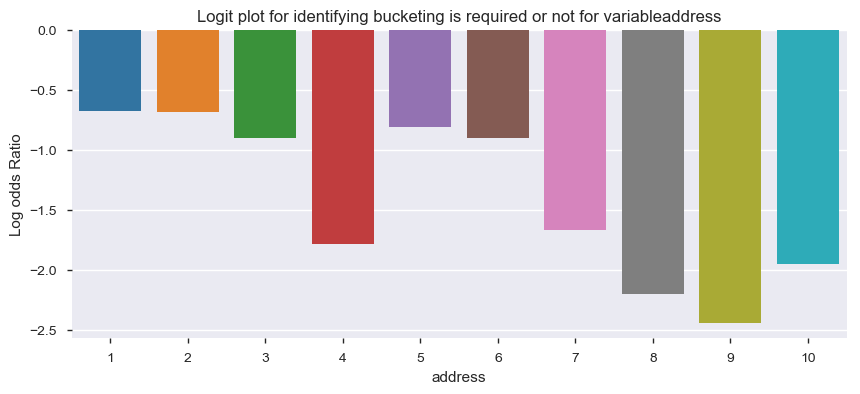

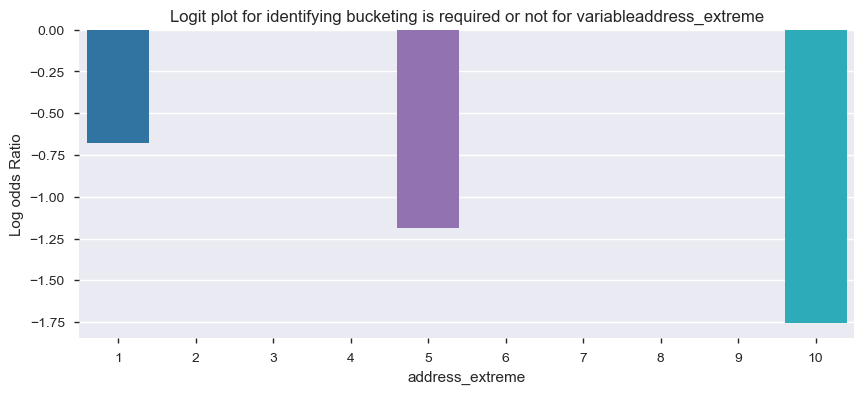

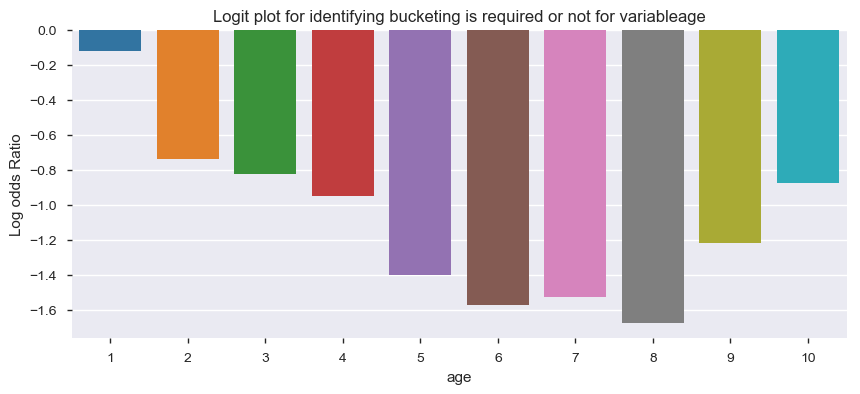

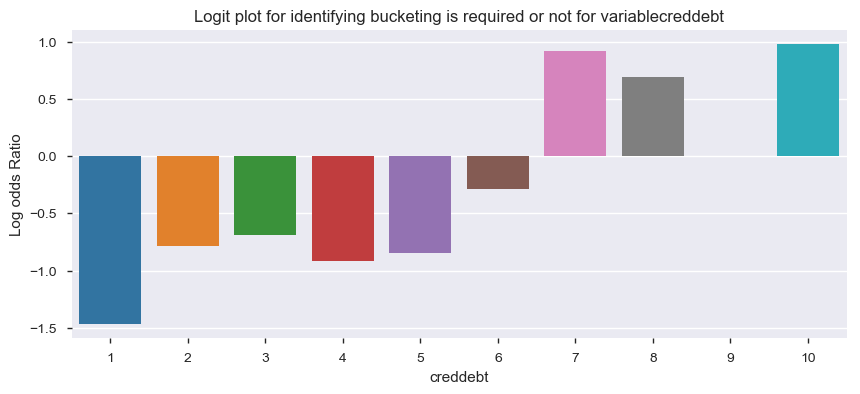

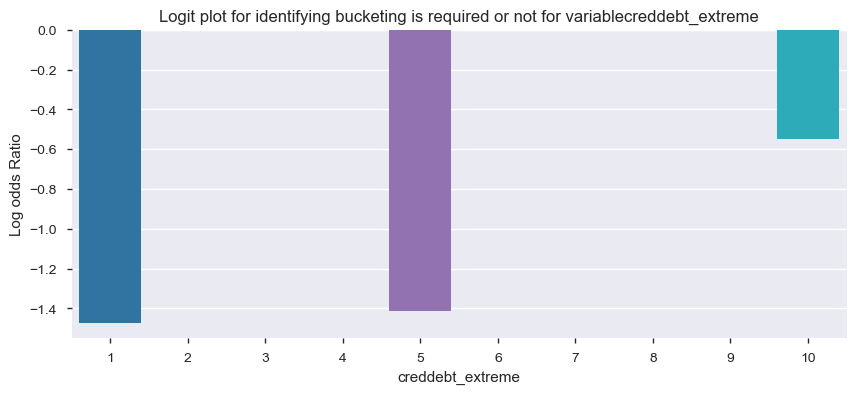

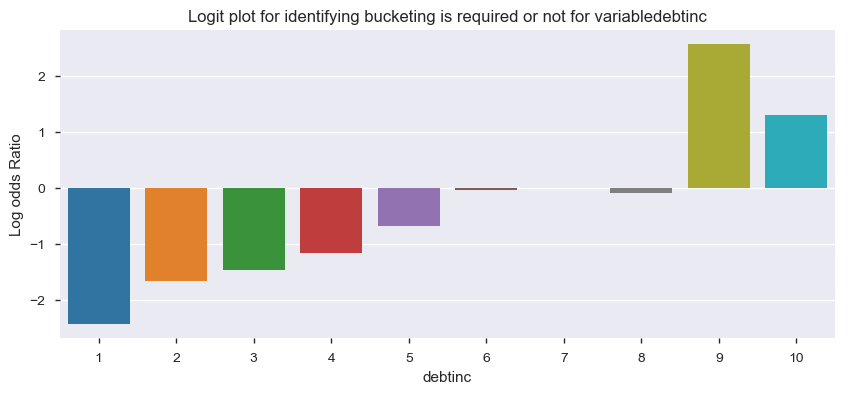

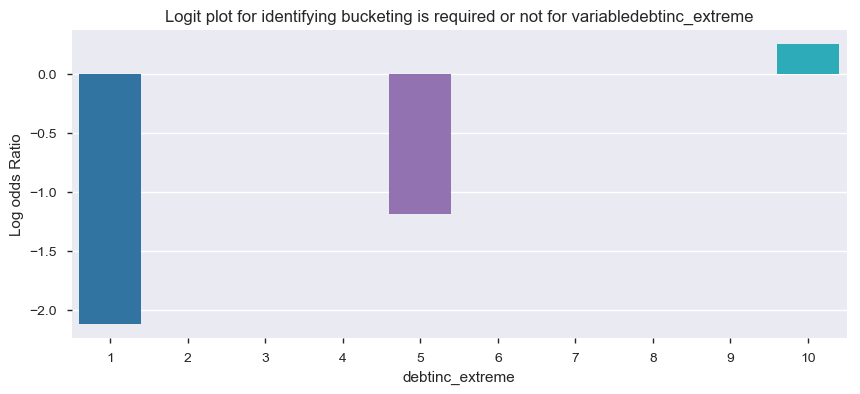

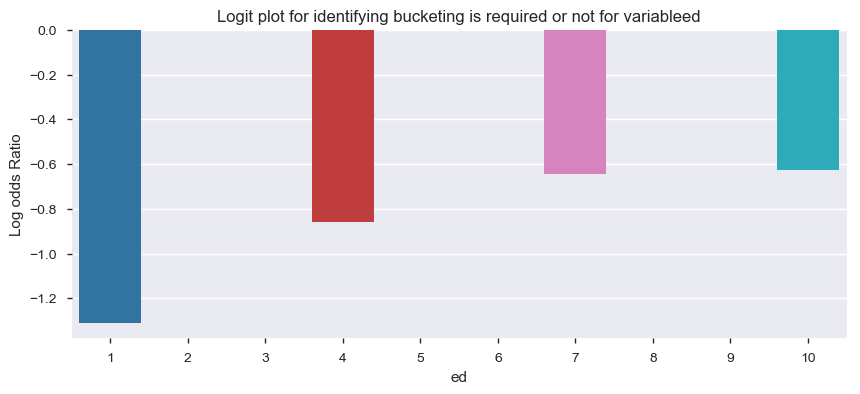

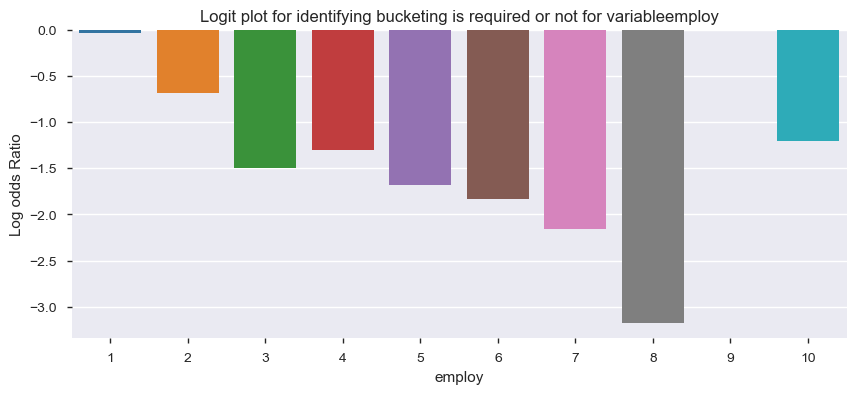

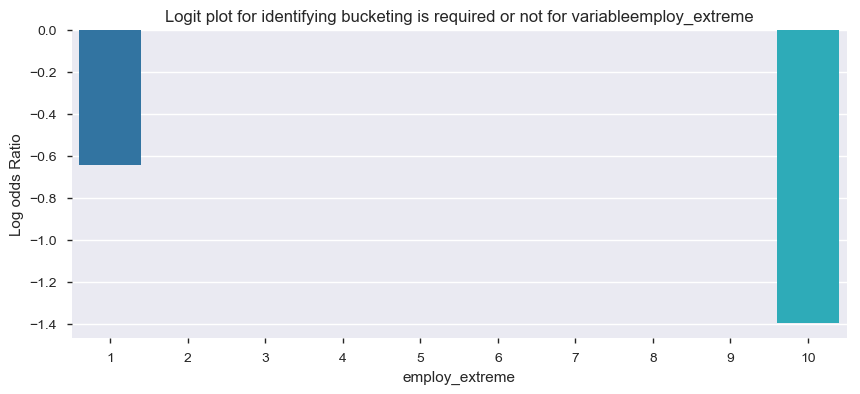

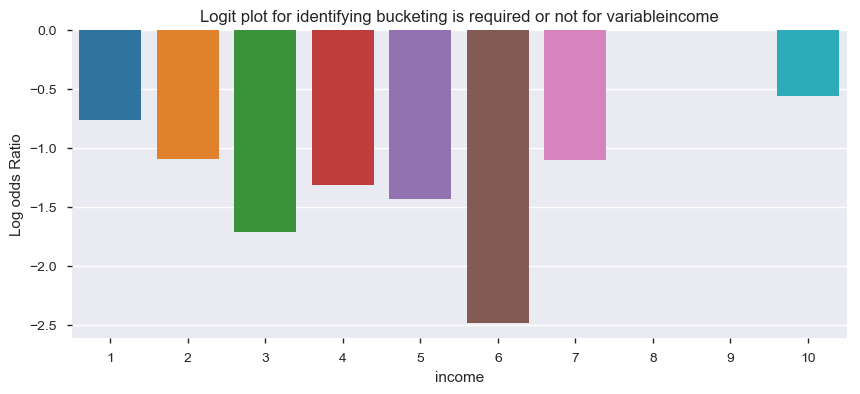

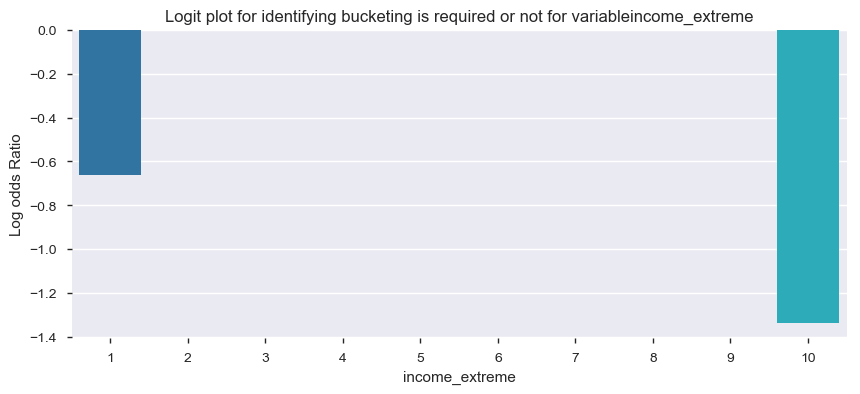

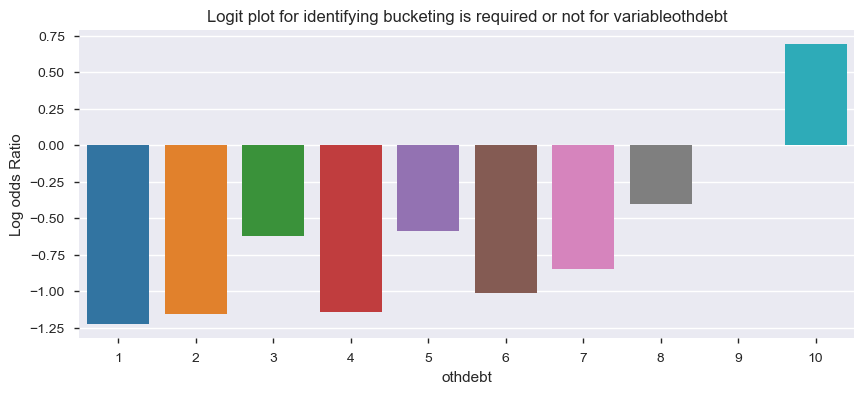

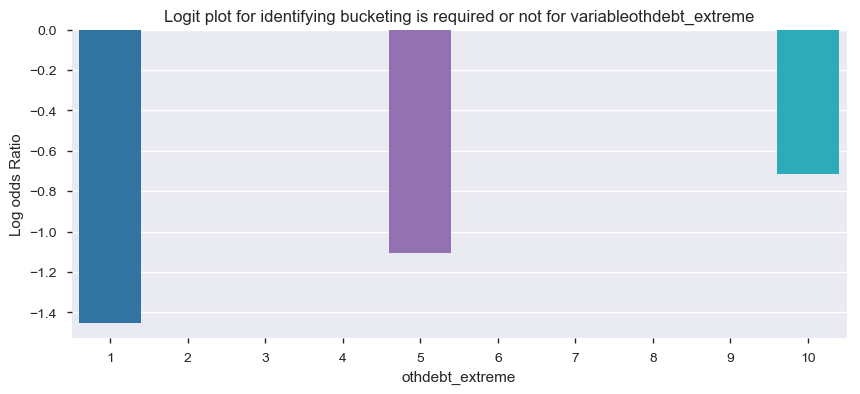

In [47]:
for n1 in bankloans_existing.columns.difference(['default']):   
    binned=pd.cut(bankloans_existing[n1],bins=10,labels=list(range(1,11)))
    binned=binned.dropna()
    ser=bankloans_existing.groupby(binned)['default'].sum()/(bankloans_existing.groupby(binned)['default'].count()-bankloans_existing.groupby(binned)['default'].sum())
    ser=np.log(ser)
    fig,axes=plt.subplots(figsize=(10,4))
    sns.barplot(x=ser.index,y=ser)
    plt.ylabel('Log odds Ratio')
    plt.title(str('Logit plot for identifying bucketing is required or not for variable')+str(n1))

In [24]:
bankloans_existing.columns

Index([u'default', u'ed', u'age', u'address', u'employ', u'debtinc', u'income',
       u'othdebt', u'creddebt', u'address_extreme_1', u'address_extreme_2',
       u'creddebt_extreme_1', u'creddebt_extreme_2', u'debtinc_extreme_1',
       u'debtinc_extreme_2', u'employ_extreme_1', u'income_extreme_1',
       u'othdebt_extreme_1', u'othdebt_extreme_2'],
      dtype='object')

In [32]:
somersd_df=pd.DataFrame()
num_features=['ed','age','address_extreme_1','address_extreme_2','othdebt_extreme_1','othdebt_extreme_2','creddebt_extreme_1','creddebt_extreme_2','debtinc_extreme_1','debtinc_extreme_2','employ_extreme_1','income_extreme_1']
for n1 in num_features:
    logreg=sm.logit(formula=str('default ~ ')+str(n1),data=bankloans_existing)
    result=logreg.fit()
    summ=result.summary()
    y_score=pd.DataFrame(result.predict())
    y_score.columns=['Score']
    somerd=2*metrics.roc_auc_score(bankloans_existing['default'],y_score)-1
    temp=pd.DataFrame([n1,somerd]).T
    temp.columns=['Var_name','SomersD']
    somersd_df=pd.concat([somersd_df,temp],axis=0)
    
somersd_df

Optimization terminated successfully.
         Current function value: 0.567774
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564673
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573242
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566161
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.574356
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567457
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569965
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.555621
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572653
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.520931
  

,Var_name,SomersD
0,ed,0.148302
0,age,0.206329
0,address_extreme_1,0.0564628
0,address_extreme_2,0.108941
0,othdebt_extreme_1,0.0205367
0,othdebt_extreme_2,0.132712
0,creddebt_extreme_1,0.096363
0,creddebt_extreme_2,0.218548
0,debtinc_extreme_1,0.0699496
0,debtinc_extreme_2,0.313706


In [33]:
num_features=['ed','age','address_extreme_1','address_extreme_2','othdebt_extreme_1','othdebt_extreme_2','creddebt_extreme_1','creddebt_extreme_2','debtinc_extreme_1','debtinc_extreme_2','employ_extreme_1','income_extreme_1']
X=pd.concat([bankloans_existing[num_features],bankloans_existing['default']],axis=1)
features='+'.join(num_features)
X.head()


,ed,age,address_extreme_1,address_extreme_2,othdebt_extreme_1,othdebt_extreme_2,creddebt_extreme_1,creddebt_extreme_2,debtinc_extreme_1,debtinc_extreme_2,employ_extreme_1,income_extreme_1,default
0,3.0,41.0,1,0,0,1,0,1,1,0,1,1,1.0
1,1.0,27.0,1,0,0,1,0,1,0,1,1,1,0.0
2,1.0,40.0,1,0,1,0,1,0,0,0,1,1,0.0
3,1.0,41.0,1,0,0,0,0,1,0,0,1,1,0.0
4,2.0,24.0,0,0,0,1,0,1,0,1,0,0,1.0


In [34]:
features

'ed+age+address_extreme_1+address_extreme_2+othdebt_extreme_1+othdebt_extreme_2+creddebt_extreme_1+creddebt_extreme_2+debtinc_extreme_1+debtinc_extreme_2+employ_extreme_1+income_extreme_1'

In [35]:
a,b= dmatrices(formula_like='default ~ '+features,data=X,return_type='dataframe')
vif=pd.DataFrame()
vif['VIF Factor']=[variance_inflation_factor(b.values,i) for i in range(b.shape[1])]
vif["features"] = b.columns

In [36]:
vif

,VIF Factor,features
0,35.269861,Intercept
1,1.066689,ed
2,1.784344,age
3,1.258623,address_extreme_1
4,1.636275,address_extreme_2
5,1.987000,othdebt_extreme_1
6,3.570001,othdebt_extreme_2
7,1.554763,creddebt_extreme_1
8,2.408441,creddebt_extreme_2
9,2.420362,debtinc_extreme_1


In [37]:
train_features = X.columns.difference(['default'])
train_X, test_X = train_test_split(X, test_size=0.3, random_state=42)
train_X.columns

Index([u'ed', u'age', u'address_extreme_1', u'address_extreme_2',
       u'othdebt_extreme_1', u'othdebt_extreme_2', u'creddebt_extreme_1',
       u'creddebt_extreme_2', u'debtinc_extreme_1', u'debtinc_extreme_2',
       u'employ_extreme_1', u'income_extreme_1', u'default'],
      dtype='object')

In [38]:
logreg = sm.logit(formula='default ~ ' + "+".join(train_features), data=train_X)
result = logreg.fit()
summ = result.summary()
summ

Optimization terminated successfully.
         Current function value: 0.495824
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                default   No. Observations:                  490
Model:                          Logit   Df Residuals:                      477
Method:                           MLE   Df Model:                           12
Date:                Thu, 21 Feb 2019   Pseudo R-squ.:                  0.1549
Time:                        07:21:35   Log-Likelihood:                -242.95
converged:                       True   LL-Null:                       -287.47
                                        LLR p-value:                 7.578e-14
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -1.4367      0.652     -2.205      0.027      -2.714      -0.160
address_extreme_1     -0.4109      0.256     -1.602      0.109      -0.914       0.092
address_extreme_2     -0.8805      0.400     -2.203      0.028      -1.664      -0.097
age                   -0.0016      0.018     -0.091      0.928      -0.037       0.034
creddebt_extreme_1    -0.1843      0.334     -0.552      0.581      -0.839       0.470
creddebt_extreme_2     0.6139      0.355      1.731      0.083      -0.081       1.309
debtinc_extreme_1      0.4920      0.386      1.273      0.203      -0.265       1.249
debtinc_extreme_2      1.6460      0.516      3.190      0.001       0.635       2.657
ed                     0.3102      0.120      2.595      0.009       0.076       0.545
employ_extreme_1      -0.5245      0.252     -2.080      0.038      -1.019      -0.030
income_extreme_1      -0.7170      0.324     -2.215      0.027      -1.351      -0.082
othdebt_extreme_1     -0.0289      0.343     -0.084      0.933      -0.701       0.643
othdebt_extreme_2      0.0577      0.455      0.127      0.899      -0.834       0.949
======================================================================================
"""

In [39]:
train_gini = 2*metrics.roc_auc_score(train_X['default'], result.predict()) - 1
print("The Gini Index for the model built on the Train Data is : ", train_gini)

test_gini = 2*metrics.roc_auc_score(test_X['default'], result.predict(test_X)) - 1
print("The Gini Index for the model built on the Test Data is : ", test_gini)

('The Gini Index for the model built on the Train Data is : ', 0.5328693610598694)
('The Gini Index for the model built on the Test Data is : ', 0.6928634807960452)


In [40]:
## Intuition behind ROC curve - predicted probability as a tool for separating the '1's and '0's
train_predicted_prob = pd.DataFrame(result.predict(train_X))
train_predicted_prob.columns = ['prob']
train_actual = train_X['default']
# making a DataFrame with actual and prob columns
train_predict = pd.concat([train_actual, train_predicted_prob], axis=1)
train_predict.columns = ['actual','prob']
train_predict.head()

,actual,prob
357,1.0,0.559041
649,0.0,0.739464
291,0.0,0.107634
420,1.0,0.267994
177,0.0,0.246806


In [41]:
test_predicted_prob = pd.DataFrame(result.predict(test_X))
test_predicted_prob.columns = ['prob']
test_actual = test_X['default']
# making a DataFrame with actual and prob columns
test_predict = pd.concat([test_actual, test_predicted_prob], axis=1)
test_predict.columns = ['actual','prob']
test_predict.head()

,actual,prob
158,1.0,0.367939
500,0.0,0.318945
396,0.0,0.354828
155,0.0,0.625155
321,1.0,0.327992


In [42]:
roc_like_df = pd.DataFrame()
train_temp = train_predict.copy()

for cut_off in np.linspace(0,1,50):
    train_temp['cut_off'] = cut_off
    train_temp['predicted'] = train_temp['prob'].apply(lambda x: 0.0 if x < cut_off else 1.0)
    train_temp['tp'] = train_temp.apply(lambda x: 1.0 if x['actual']==1.0 and x['predicted']==1 else 0.0, axis=1)
    train_temp['fp'] = train_temp.apply(lambda x: 1.0 if x['actual']==0.0 and x['predicted']==1 else 0.0, axis=1)
    train_temp['tn'] = train_temp.apply(lambda x: 1.0 if x['actual']==0.0 and x['predicted']==0 else 0.0, axis=1)
    train_temp['fn'] = train_temp.apply(lambda x: 1.0 if x['actual']==1.0 and x['predicted']==0 else 0.0, axis=1)
    sensitivity = train_temp['tp'].sum() / (train_temp['tp'].sum() + train_temp['fn'].sum())
    specificity = train_temp['tn'].sum() / (train_temp['tn'].sum() + train_temp['fp'].sum())
    roc_like_table = pd.DataFrame([cut_off, sensitivity, specificity]).T
    roc_like_table.columns = ['cutoff', 'sensitivity', 'specificity']
    roc_like_df = pd.concat([roc_like_df, roc_like_table], axis=0)


In [75]:
roc_like_df

,cutoff,sensitivity,specificity
0,0.000000,1.000000,0.000000
0,0.020408,1.000000,0.000000
0,0.040816,1.000000,0.047753
0,0.061224,0.992537,0.098315
0,0.081633,0.970149,0.151685
0,0.102041,0.955224,0.221910
0,0.122449,0.902985,0.308989
0,0.142857,0.895522,0.365169
0,0.163265,0.850746,0.455056
0,0.183673,0.835821,0.494382


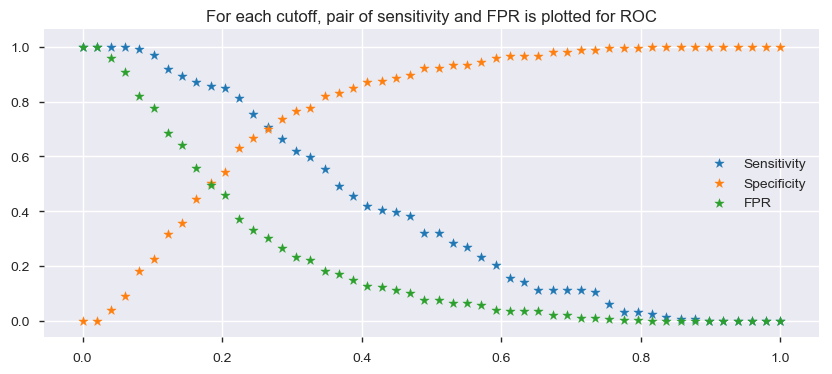

In [43]:
plt.subplots(figsize=(10,4))
plt.scatter(roc_like_df['cutoff'], roc_like_df['sensitivity'], marker='*', label='Sensitivity')
plt.scatter(roc_like_df['cutoff'], roc_like_df['specificity'], marker='*', label='Specificity')
plt.scatter(roc_like_df['cutoff'], 1-roc_like_df['specificity'], marker='*', label='FPR')
plt.title('For each cutoff, pair of sensitivity and FPR is plotted for ROC')
plt.legend()

In [44]:
roc_like_df['total'] = roc_like_df['sensitivity'] + roc_like_df['specificity']
roc_like_df[roc_like_df['total']==roc_like_df['total'].max()]

,cutoff,sensitivity,specificity,total
0,0.22449,0.813433,0.629213,1.442646


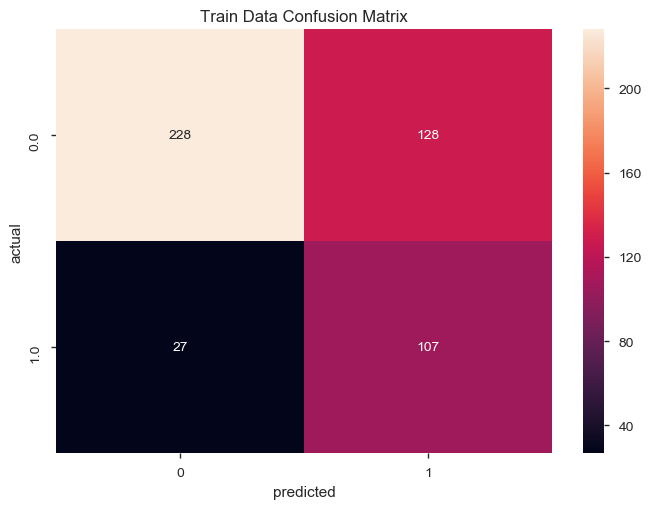

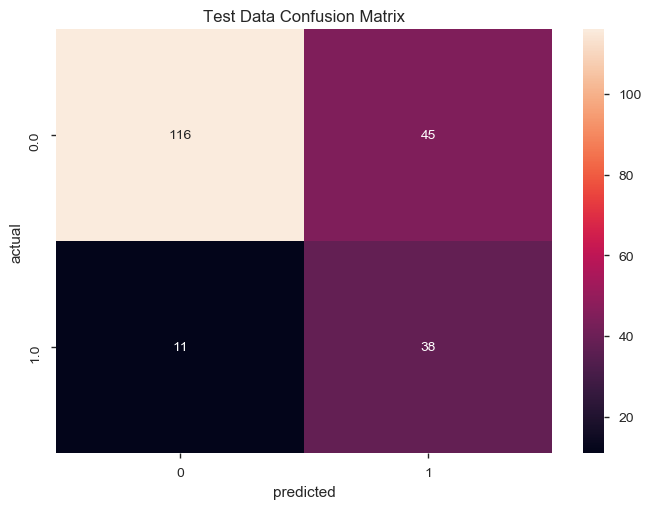

In [45]:
test_predict['predicted'] = test_predict['prob'].apply(lambda x: 1 if x > 0.23 else 0)
train_predict['predicted'] = train_predict['prob'].apply(lambda x: 1 if x > 0.23 else 0)
sns.heatmap(pd.crosstab(train_predict['actual'], train_predict['predicted']), annot=True, fmt='.0f')
plt.title('Train Data Confusion Matrix')
plt.show()
sns.heatmap(pd.crosstab(test_predict['actual'], test_predict['predicted']), annot=True, fmt='.0f')
plt.title('Test Data Confusion Matrix')
plt.show()

In [46]:
print("The overall accuracy score for the Train Data is : ", metrics.accuracy_score(train_predict.actual, train_predict.predicted))
print("The overall accuracy score for the Test Data  is : ", metrics.accuracy_score(test_predict.actual, test_predict.predicted))

('The overall accuracy score for the Train Data is : ', 0.6836734693877551)
('The overall accuracy score for the Test Data  is : ', 0.7333333333333333)
